In [96]:
import os
from PIL import Image
from ultralytics import YOLO

# Path to your YOLOv8 model weights
model_path = 'best.pt'  # Replace with the path to your model weights file

# Load the YOLOv8 model
model = YOLO(model_path)

# Define the image folder
image_folder = 'split_dataset/val/images'

# Create a directory to save predictions
os.makedirs('predictions', exist_ok=True)

# Define the target size for resizing
target_size = (640, 640)

# Process each image in the folder
for image_name in os.listdir(image_folder):
    if image_name.endswith(('.png', '.jpg', '.jpeg')):
        # Load and resize the image
        image_path = os.path.join(image_folder, image_name)
        image = Image.open(image_path).convert('RGB')
        image_resized = image.resize(target_size)
        
        # Perform inference
        results = model(image_resized)
        
        # Get the predictions
        predictions = results[0].boxes.xyxyn.cpu().numpy()  # xyxy format
        confidences = results[0].boxes.conf.cpu().numpy()  # confidences
        classes = results[0].boxes.cls.cpu().numpy()  # class labels
        
        # Save the predictions
        prediction_path = os.path.join('predictions', f'{os.path.splitext(image_name)[0]}_pred.txt')
        with open(prediction_path, 'w') as f:
            for i in range(len(predictions)):
                x1, y1, x2, y2 = predictions[i]
                conf = confidences[i]
                cls = int(classes[i])
                class_name = model.names[cls]
                f.write(f'{class_name} {conf} {x1} {y1} {x2} {y2}\n')
        
        # print(f'Predictions saved for {image_name}')

print('Done predicting all images.')


0: 640x640 1 adj, 1632.6ms
Speed: 4.0ms preprocess, 1632.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 1687.0ms
Speed: 4.0ms preprocess, 1687.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 1613.0ms
Speed: 3.0ms preprocess, 1613.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 1586.5ms
Speed: 3.1ms preprocess, 1586.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 1683.8ms
Speed: 4.0ms preprocess, 1683.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 1655.8ms
Speed: 3.0ms preprocess, 1655.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 1696.0ms
Speed: 3.0ms preprocess, 1696.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 1645.7ms
Speed: 3.0ms 

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import cv2
import os
import random

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2
import matplotlib.pyplot as plt
import shutil

In [98]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    Parameters:
    box1: list or array of [x1, y1, x2, y2]
    box2: list or array of [x1, y1, x2, y2]
    Returns:
    float: IoU value
    """
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    if x1_inter < x2_inter and y1_inter < y2_inter:
        inter_area = (x2_inter - x1_inter) * (y2_inter - y1_inter)
    else:
        inter_area = 0.0

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area != 0 else 0.0

def calculate_f1_iou(predictions, ground_truths, iou_threshold=0.5):
    """
    Calculate the mean F1 score considering IoU for object detection.
    Parameters:
    predictions: list of tuples [(class_label, [x1, y1, x2, y2]), ...]
    ground_truths: list of tuples [(class_label, [x1, y1, x2, y2]), ...]
    iou_threshold: float, threshold to consider a prediction as true positive
    Returns:
    float: mean F1 score
    """
    TP = 0
    FP = 0
    FN = 0

    matched_gt = set()

    for pred_class, pred_box in predictions:
        iou_max = 0
        matched_gt_idx = -1
        for i, (gt_class, gt_box) in enumerate(ground_truths):
            if pred_class == gt_class:
                iou = calculate_iou(pred_box, gt_box)
                if iou > iou_max:
                    iou_max = iou
                    matched_gt_idx = i

        if iou_max >= iou_threshold and matched_gt_idx not in matched_gt:
            TP += 1
            matched_gt.add(matched_gt_idx)
        else:
            FP += 1

    FN = len(ground_truths) - len(matched_gt)

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return f1_score

In [99]:
rename_labels_dict = {
    '0':'adj',
    '1':'int',
    '2':'geo',
    '3':'pro',
    '4':'non'
}

In [100]:
import os
import pandas as pd

# Define the folder containing the prediction files
predictions_folder = 'predictions'
true_folder = 'split_dataset/val/labels'

# Initialize the list to store the formatted prediction

f1_iou_score_list = []

submission = pd.DataFrame()

# Process each prediction file in the folder
for prediction_file in os.listdir(predictions_folder):
    if prediction_file.endswith('_pred.txt'):
        
        formatted_predictions = []
        
        # Construct the full path to the prediction file
        prediction_path = os.path.join(predictions_folder, prediction_file)
        
        # Read the prediction file
        with open(prediction_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) == 6:
                    class_name = parts[0]
                    conf = float(parts[1])
                    x1 = float(parts[2])
                    y1 = float(parts[3])
                    x2 = float(parts[4])
                    y2 = float(parts[5])
                    
                    # Append the formatted prediction to the list
                    formatted_predictions.append((class_name, [x1, y1, x2, y2]))
                    
                    x_center = (x1 + x2) / 2
                    y_center = (y1 + y2) / 2
                    width = x2 - x1
                    height = y2 - y1
                    
                    img_name = prediction_file.split('_')[0] + '.jpg'
                    
                    submission_df = pd.DataFrame([[img_name, class_name, x_center, y_center, width, height]], columns=['filename','class_id','rel_x','rel_y','width','height'])
                    submission = pd.concat([submission, submission_df])
                    
        filename = prediction_file.split('_')[0] + '.txt'
        true_path = os.path.join(true_folder, filename)
        
        formatted_true = []
        
        # Read the prediction file
        with open(true_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_name = parts[0]
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])
                    
                    x1 = x_center - width / 2
                    y1 = y_center - height / 2
                    x2 = x_center + width / 2
                    y2 = y_center + height / 2
                    
                    # Append the formatted prediction to the list
                    class_name = rename_labels_dict[class_name]
                    formatted_true.append((class_name, [x1, y1, x2, y2]))
                    
        f1_iou_score = calculate_f1_iou(formatted_predictions, formatted_true)
        f1_iou_score_list.append(f1_iou_score)
        
print("Mean F1 score considering IoU and class labels:", np.mean(f1_iou_score_list))

Mean F1 score considering IoU and class labels: 0.10637510637510639


In [43]:
rename_labels_dict_new = {
    'adj':'0',
    'int':'1',
    'geo':'2',
    'pro':'3',
    'non':'4'
}

In [101]:
submission['class_id'] = submission['class_id'].map(rename_labels_dict_new)

In [102]:
submission

filename class_id     rel_x     rel_y     width    height
0    1 (11).jpg        0  0.419021  0.615139  0.020848  0.041929
0   4 (102).jpg        0  0.779680  0.477892  0.022559  0.022993
0   4 (102).jpg        0  0.280300  0.470649  0.023069  0.036880
0   4 (102).jpg        2  0.481468  0.360778  0.139989  0.106903
0   4 (102).jpg        2  0.481619  0.390528  0.141478  0.119704
..          ...      ...       ...       ...       ...       ...
0    8 (96).jpg        2  0.568301  0.587665  0.147140  0.085909
0    9 (68).jpg        2  0.612336  0.293533  0.146924  0.152172
0    9 (68).jpg        2  0.617930  0.298369  0.125527  0.115461
0    9 (68).jpg        2  0.584673  0.264463  0.049322  0.038649
0    9 (68).jpg        2  0.615711  0.262370  0.144929  0.075757

[124 rows x 6 columns]

In [103]:
submission.to_csv('submission.csv', sep=';', index=False)

In [26]:
img_folder = 'split_dataset/val/images'

filename = prediction_file.split('_')[0] + '.jpg'
img_path = os.path.join(img_folder, filename)

In [27]:
img_path

'split_dataset/val/images\\9 (71).jpg'

In [28]:
def load_class_names(file_path):
    with open(file_path, 'r') as file:
        class_names = [line.strip() for line in file.readlines()]
    return class_names

def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

def load_labels(label_path):
    with open(label_path, 'r') as file:
        labels = [line.strip().split() for line in file.readlines()]
    return labels

In [37]:
# Путь к директории с изображениями и файлами разметки
data_dir = 'split_dataset/val/images'
label_dir = 'split_dataset/val/labels'
label_dir_pred = 'predictions'

# Путь к файлу с именами классов
class_names_file = 'dataset/classes.txt'

# Загрузка имен классов
class_names = load_class_names(class_names_file)

# Получение всех файлов из директории
files = os.listdir(data_dir)

# Фильтрация изображений и файлов разметки
image_files = [f for f in files if f.endswith(('.jpg', '.png', '.jpeg'))]

In [54]:
def plot_image_with_labels(image, labels, labels_pred,  class_names):
    plt.imshow(image)
    height, width, _ = image.shape
    for label in labels:
        class_id, x_center, y_center, bbox_width, bbox_height = map(float, label)
        x_center *= width
        y_center *= height
        bbox_width *= width
        bbox_height *= height
        x_min = x_center - bbox_width / 2
        y_min = y_center - bbox_height / 2
        rect = plt.Rectangle((x_min, y_min), bbox_width, bbox_height, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        
        # Добавление текста с именем класса
        class_name = class_names[int(class_id)]
        plt.text(x_min, y_min - 10, class_name, color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
        
    for label in labels_pred:
        class_id, dd, x_left, y_top, x_right, y_bot = label
        
        x_left = float(x_left)
        y_top = float(y_top)
        x_right = float(x_right)
        y_bot = float(y_bot)
        
        bbox_width = x_right - x_left
        bbox_height = y_top - y_bot
        
        x_min = x_left
        y_min = y_bot
        rect = plt.Rectangle((x_min, y_min), bbox_width, bbox_height, edgecolor='k', facecolor='none')
        plt.gca().add_patch(rect)
        
        # Добавление текста с именем класса
        # class_name = class_names[int(class_id)]
        plt.text(x_min, y_min - 10, class_id, color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.show()

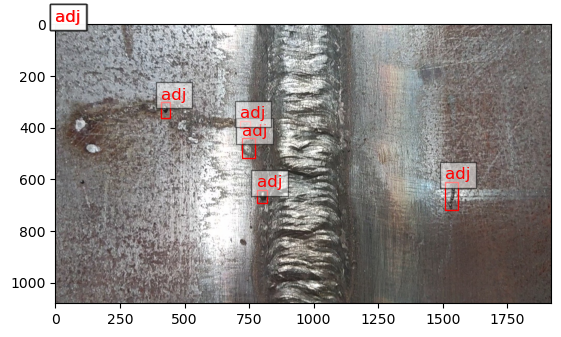

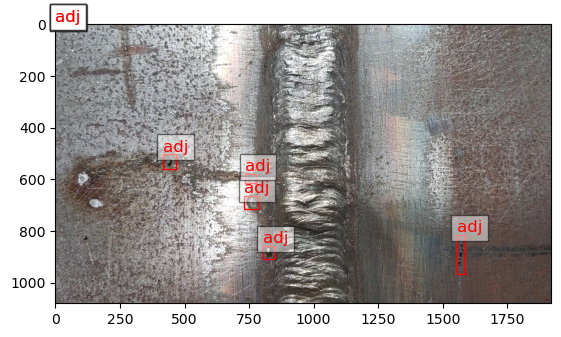

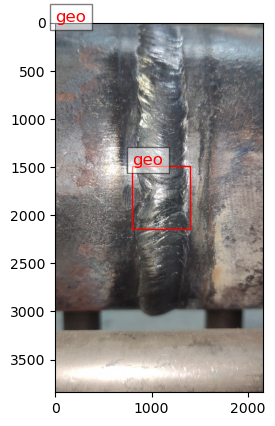

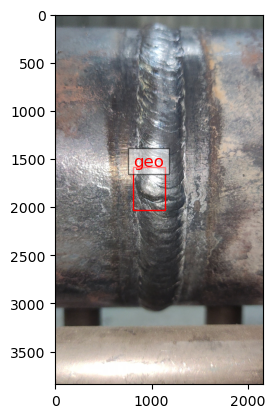

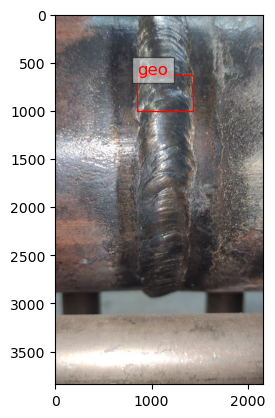

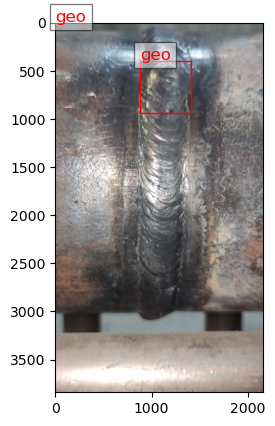

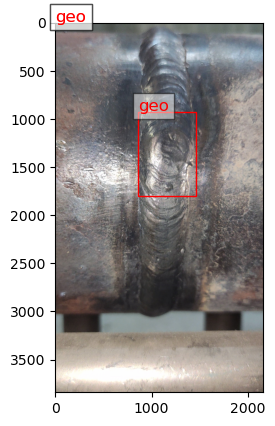

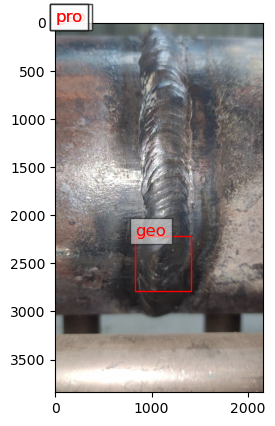

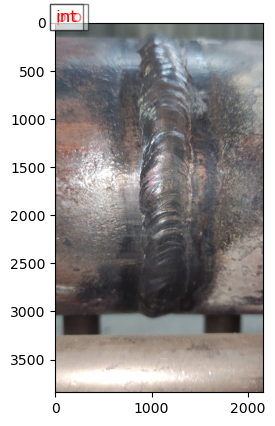

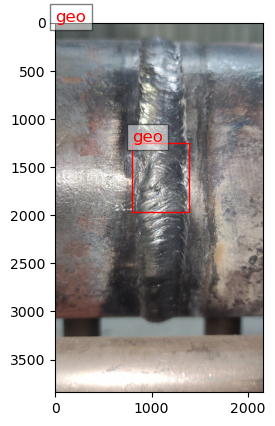

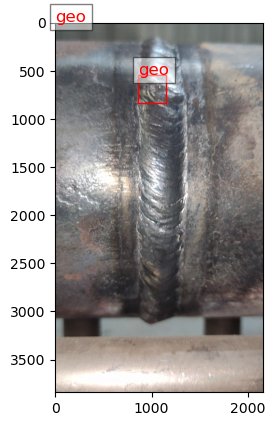

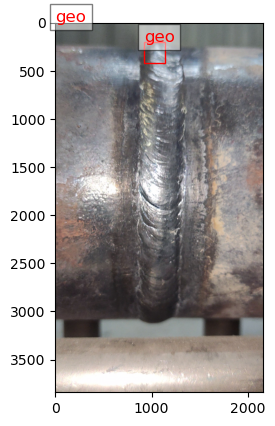

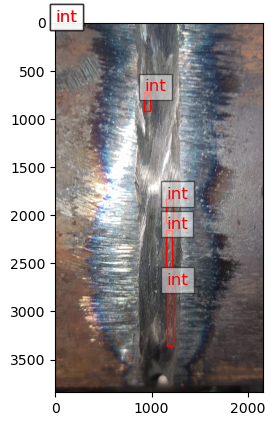

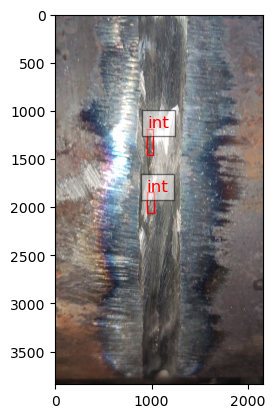

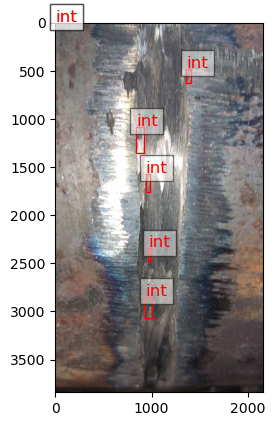

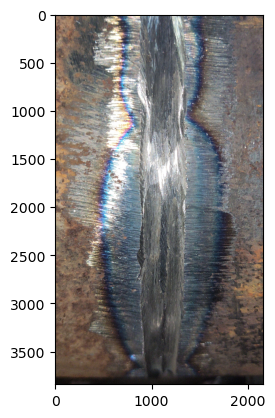

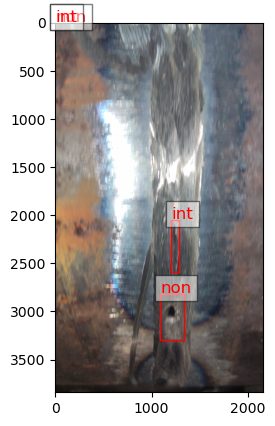

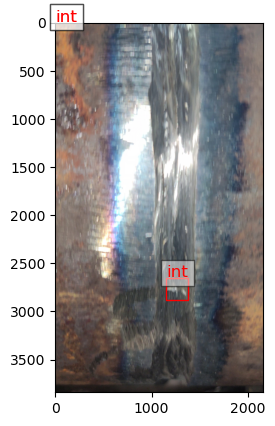

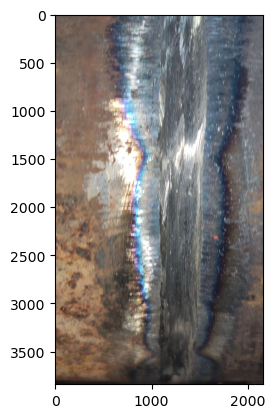

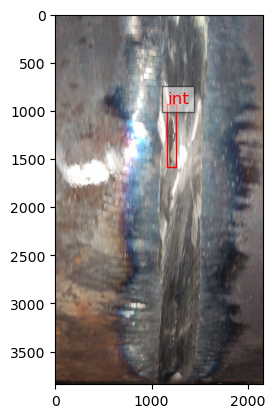

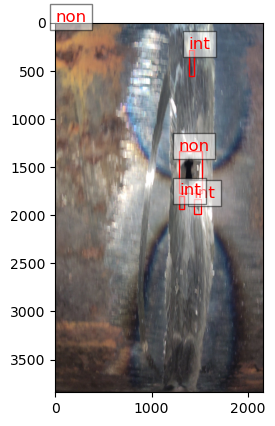

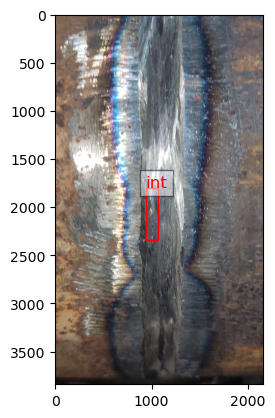

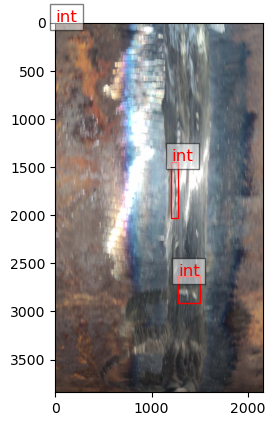

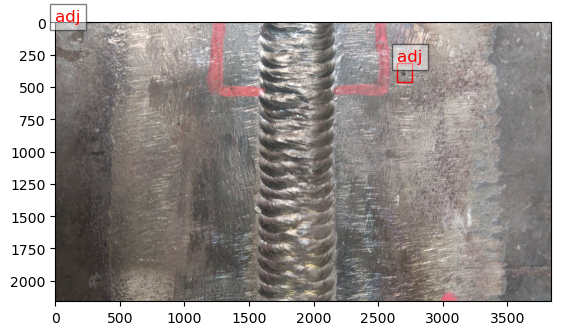

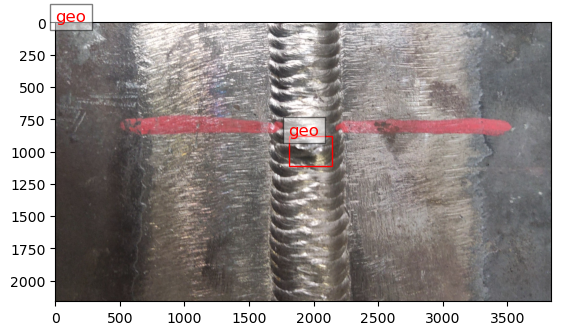

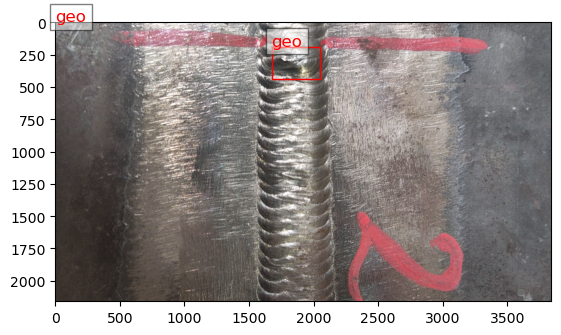

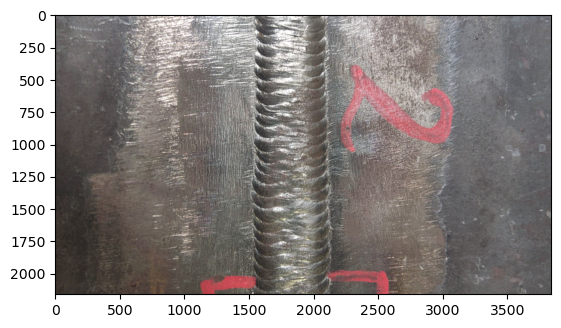

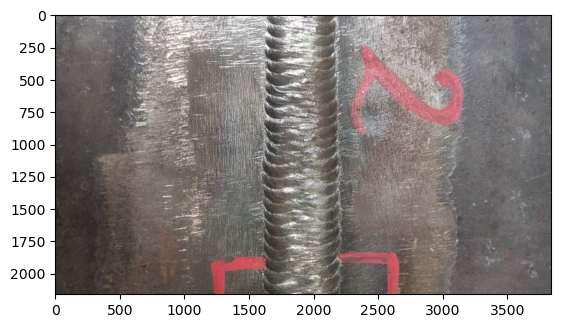

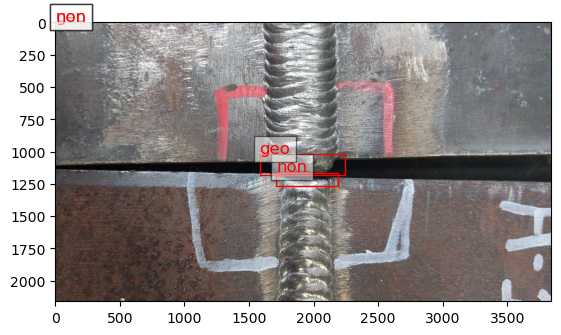

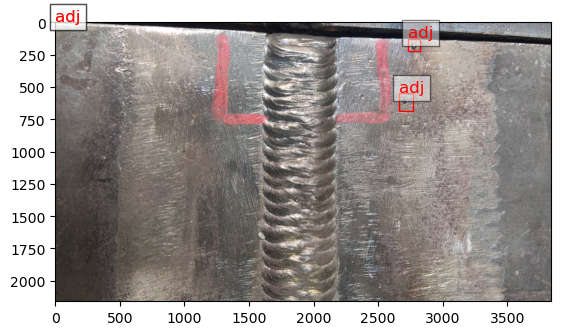

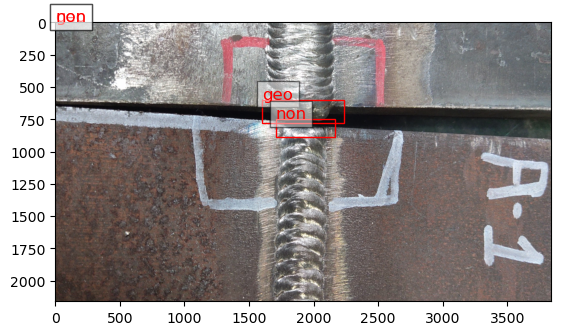

KeyboardInterrupt: 

In [55]:
# Пример загрузки и отображения одного изображения и его разметки
for image_file in image_files:
    image_path = os.path.join(data_dir, image_file)
    label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + '.txt')
    label_path_pred = os.path.join(label_dir_pred, os.path.splitext(image_file)[0] + '_pred.txt')

    if os.path.exists(label_path):
        image = load_image(image_path)
        labels = load_labels(label_path)
        labels_pred = load_labels(label_path_pred)
        plot_image_with_labels(image, labels, labels_pred, class_names)
    else:
        print(f"No label file found for image {image_file}")